<a href="https://colab.research.google.com/github/MatthewMoor/SOM-2.5PM/blob/master/SOMv9_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import somoclu
import math as mt
%matplotlib inline

In [2]:
union = pd.read_csv('Union.csv')
print(union)

        day  hour  DEWP   HUMI    PRES  TEMP    Iws  precipitation  Iprec  \
0        64     8  -6.0  59.00  1019.0   1.0   0.89            0.0    0.0   
1        64     9  -8.0  38.00  1019.0   5.0   1.78            0.0    0.0   
2        64    10  -8.0  31.00  1018.0   8.0   2.67            0.0    0.0   
3        64    12  -9.0  23.00  1017.0  11.0   4.45            0.0    0.0   
4        64    13  -9.0  22.00  1015.0  12.0   5.34            0.0    0.0   
5        64    14 -10.0  19.00  1014.0  13.0   7.13            0.0    0.0   
6        64    15  -9.0  19.00  1013.0  14.0   3.13            0.0    0.0   
7        64    16  -9.0  19.00  1013.0  14.0   4.92            0.0    0.0   
8        64    17  -8.0  23.00  1013.0  12.0   1.79            0.0    0.0   
9        64    18  -7.0  33.00  1013.0   8.0   0.45            0.0    0.0   
10       64    19  -6.0  44.00  1014.0   5.0   1.34            0.0    0.0   
11       64    20  -7.0  38.00  1014.0   6.0   2.23            0.0    0.0   

In [3]:
def data_transformation(data=None, default_data = True): 
  """Transform data in the range 0, 1"""
  if data is None and default_data == True:
    X = pd.read_csv('dust_calculation.csv')
    X = X.iloc[:, 1:]
  else:
    X = data

  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler(feature_range = (0, 1))
  X = sc.fit_transform(X)
  print(np.shape(X))
  return X

def elbow_plot(X):
  """Draws plot with which we find the cluster"""
  Sum_of_squared_distances = []
  K = range(1,10)
  for k in K:
      km = KMeans(n_clusters=k).fit(X)
      km = km.fit(X)
      Sum_of_squared_distances.append(km.inertia_)

  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()
  
def draw_umatrix(labels=None):
  if labels != None:
    return som.view_umatrix(bestmatches=True, labels=labels), som.view_component_planes()
  else:
    return som.view_umatrix(bestmatches=True), som.view_component_planes()

def get_coordinates_from_index(n, x, y):
    if n < 0:
        return (-1, -1)
    else:
        return (n % y, n // y)


def get_index_from_coordinates(c, x, y):
    if c[0] < 0 or c[1] < 0 or c[0] > y or c[1] > x:
        return -1
    else:
        return c[1]*y + c[0]


def get_neighbors_from_index(n, x, y):
    c = get_coordinates_from_index(n, x, y)
    neighbors_c = [(c[0]-1, c[1]), (c[0]+1, c[1]),
                   (c[0], c[1]-1), (c[0], c[1]+1)]
    neighbors_c = [c for c in neighbors_c
                   if c[0] >= 0 and c[1] >= 0 and c[1] < x and c[0] < y]
    neighbors = [get_index_from_coordinates(c, x, y) for c in neighbors_c]
    return list(set(neighbors))


def calculate_topographical_error(som, n_rows, n_columns):
    surface_state = som.get_surface_state()
    bmus_1st_and_2nd = np.argsort(surface_state, axis=1)[:, :2]
    all_2nd = []
    for i, second_index in enumerate(bmus_1st_and_2nd[:, 1]):
        all_2nd.append([])
        distance = surface_state[i, second_index]
        for s_i, s in enumerate(surface_state[i]):
            if abs(s-distance) < 10e-5:
                all_2nd[-1].append(s_i)
    neighbors = [get_neighbors_from_index(t, n_rows, n_columns)
                 for t in bmus_1st_and_2nd[:, 0]]

    e_t = 1-np.mean([len(set(second) & set(neighs)) > 0 for (second, neighs) in
                     zip(all_2nd, neighbors)])
    return e_t

def find_clusters(labels):
  """We find line our clusters of datasets"""
  clusters = {}
  for k in labels:  # The data instance you are interested in 
      cluster = str(som.clusters[som.bmus[k, 1], som.bmus[k, 0]])
      if not cluster in clusters.keys():
          clusters[cluster] = []
      clusters[cluster] += [k]
  import json
  print(json.dumps(clusters, sort_keys=True, indent=4))
  return clusters
  
    
 
  
def cluster_data(number_cluster, clusters):
  """Pulling out data-points in rows"""
  try:
    pulled_data = []
    detailed_cluster = clusters[number_cluster]
    for i in detailed_cluster:
      pulled_data.append(X[i])
    quantity_strings = len(pulled_data)
  except KeyError:
    print('Your data out of range!\nSolution: Enter correct cluster value, your length dict - {}'.format(len(clusters.keys())))
  print("Quantity strings in clusters - {} \n Approximate map size - {} ".format(quantity_strings,mt.sqrt(5*mt.sqrt(quantity_strings))))
  return np.asarray(pulled_data)

 
def quant_err(data):
    bmu_dists = [] 
    bmus = som.get_bmus(som.get_surface_state(data))
    bmus_feat = som.codebook
    for index, input_vector in enumerate(data):
        bmu = bmus[index]
        bmu_feat = bmus_feat[bmu[0], bmu[1]]
        bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
    return np.array(bmu_dists).mean()

def cluster_quant_err(data):
    cluster_bmu_dists = []
    for index_cluster in clusters:
        data_cluster = cluster_data(index_cluster, clusters)
        error_certain_cluster = quant_err(data_cluster)
        cluster_bmu_dists.append([index_cluster, error_certain_cluster])
    return np.array(cluster_bmu_dists)


def cluster_data_frame(number_cluster, clusters):
    detailed_cluster = [i for i in clusters[number_cluster]]
    data_cluster = union.iloc[detailed_cluster]
    return data_cluster        

In [4]:
n_rows, n_columns = 40, 40
X = data_transformation(union)
labels = range(X.shape[0])

som = somoclu.Somoclu(n_columns, n_rows, data=X, maptype="planar", initialization="pca")
som.train(epochs=1000,radius0=38, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.03, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

/home/valyay/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(100684, 10)
The topographical error obtained is: 0.3036728775177784


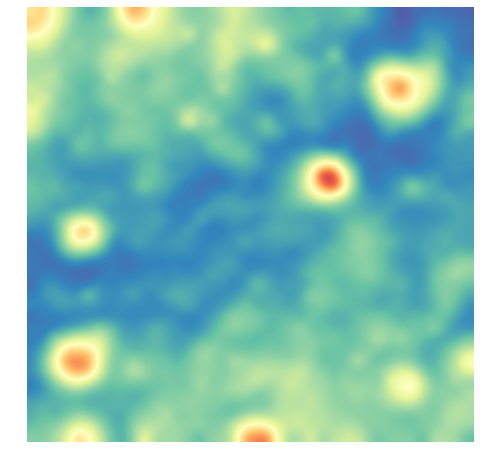

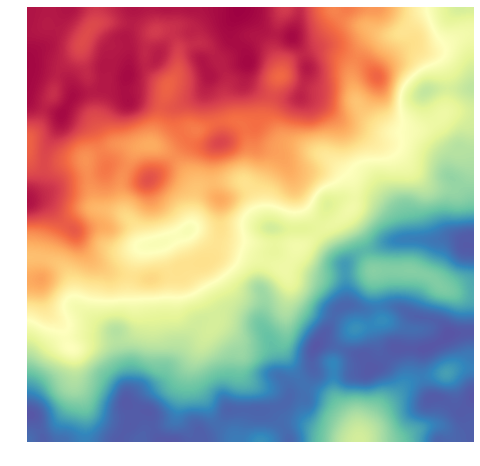

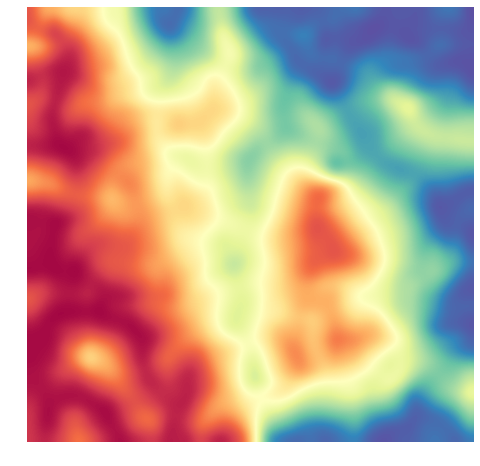

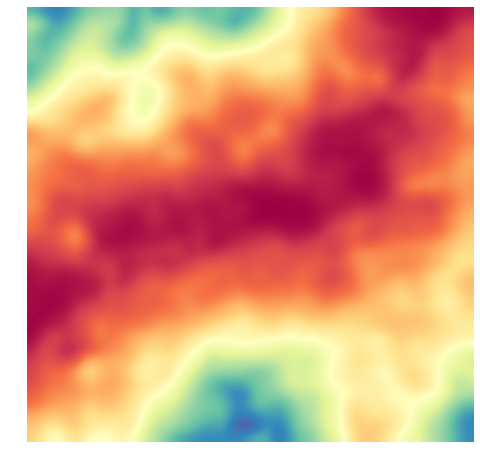

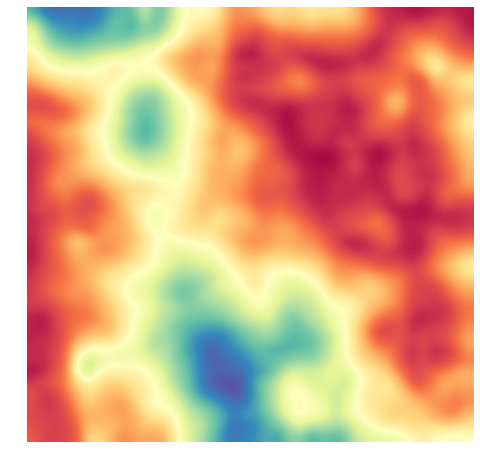

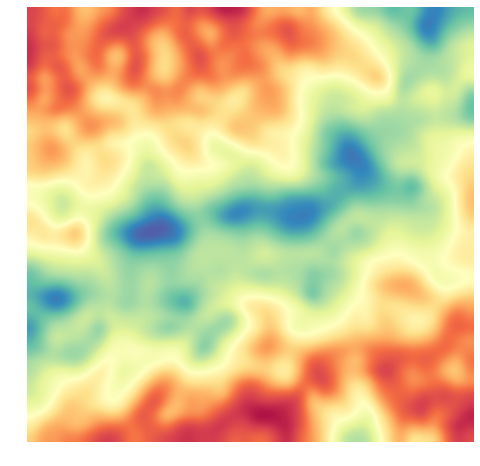

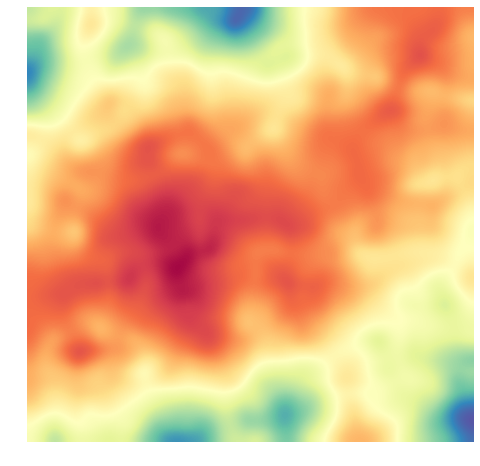

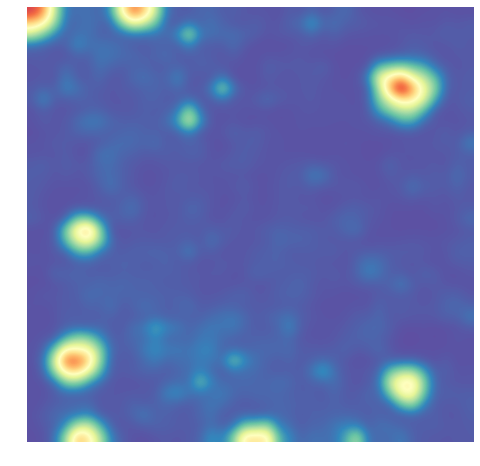

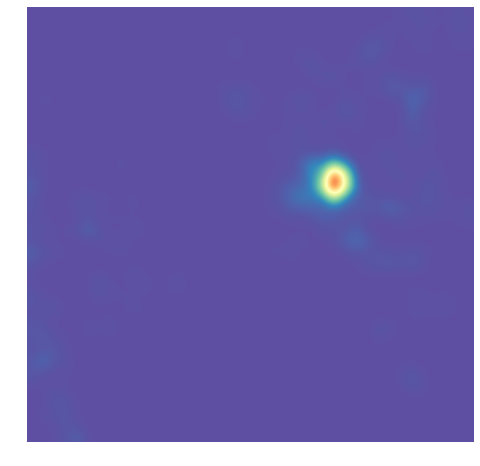

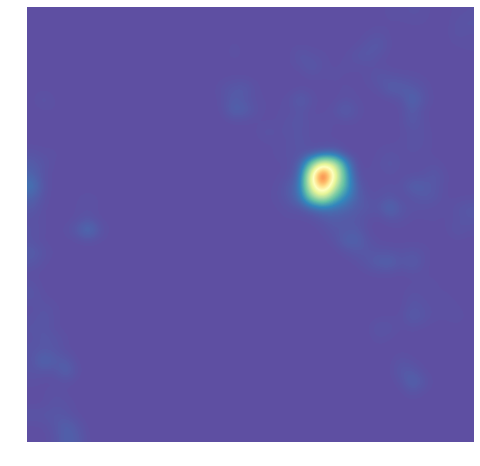

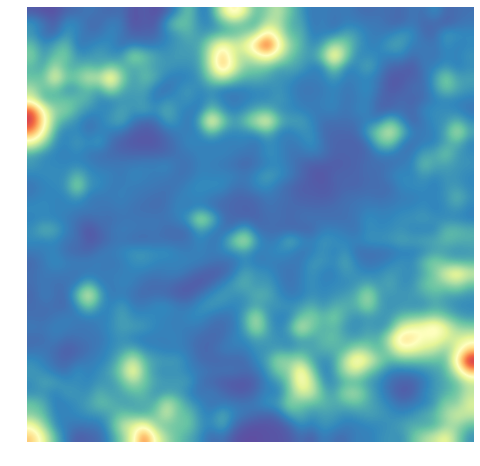

<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [5]:
som.view_umatrix()
som.view_component_planes()

In [6]:
%time som.train(epochs=10000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 20h 58min 11s, sys: 29.7 s, total: 20h 58min 40s
Wall time: 5h 19min 43s
The topographical error obtained is: 0.5977911088157006


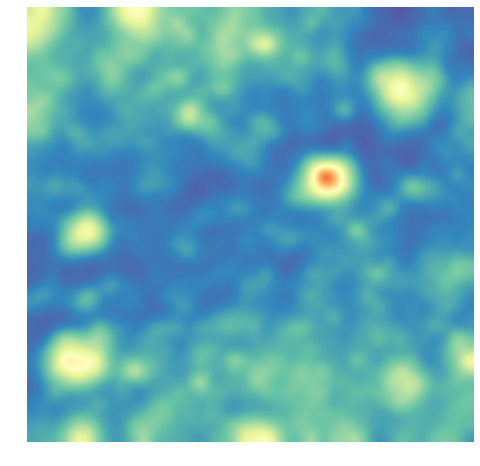

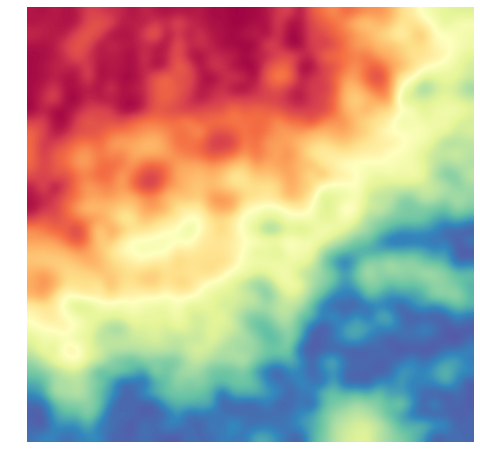

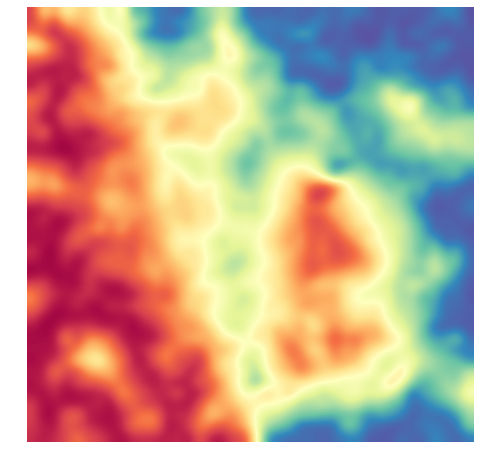

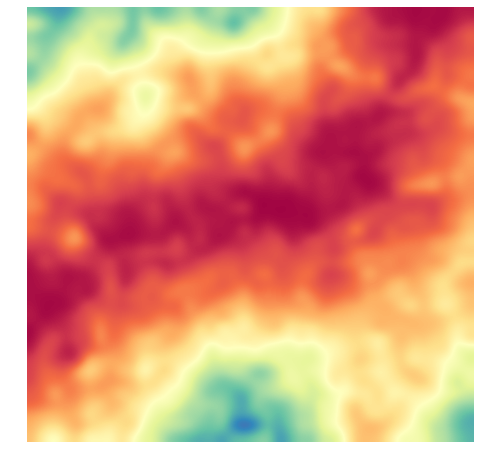

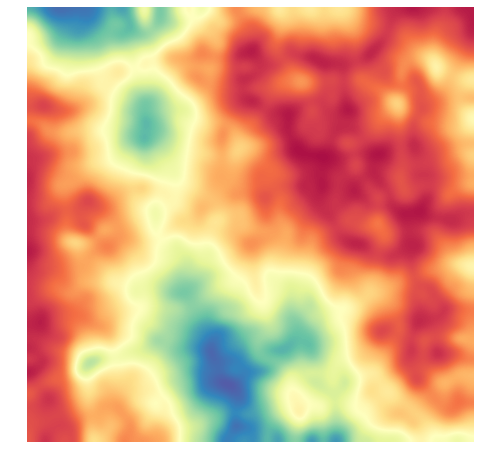

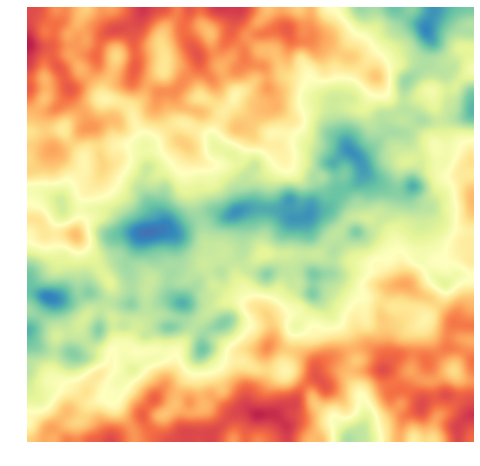

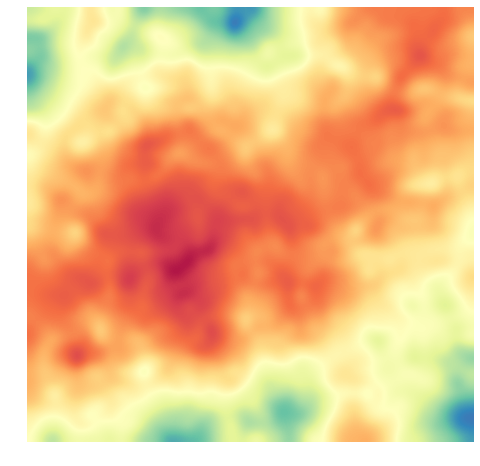

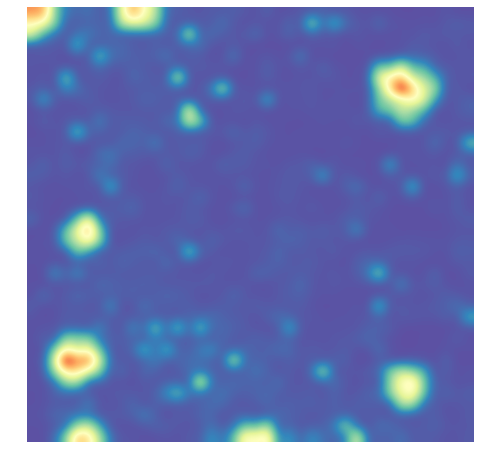

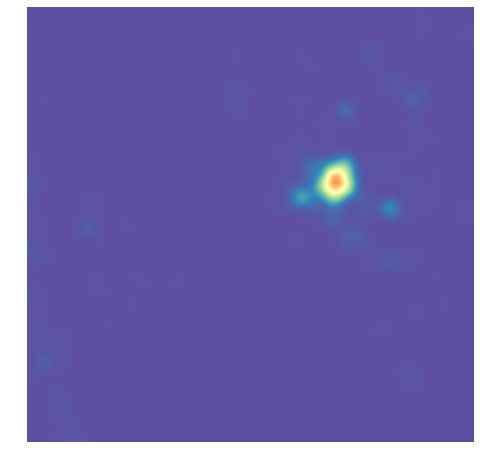

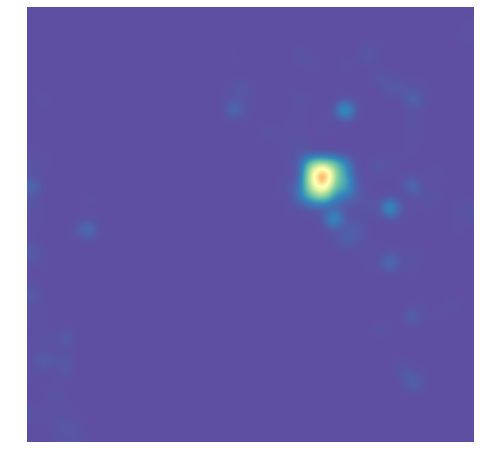

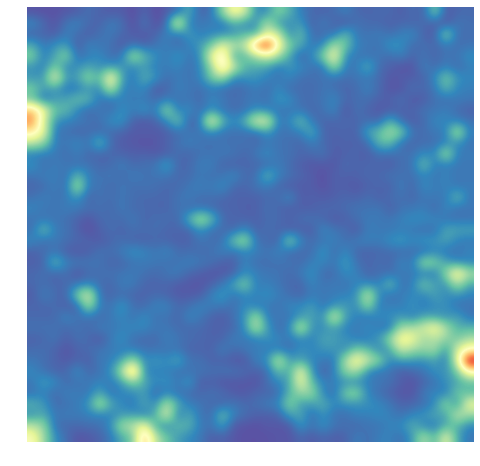

<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>

In [7]:
som.view_umatrix()
som.view_component_planes()

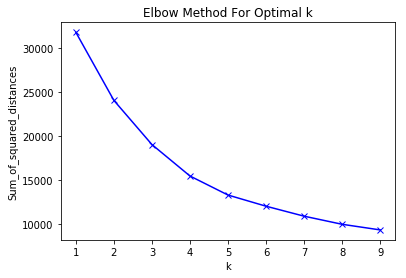

In [8]:
elbow_plot(X)

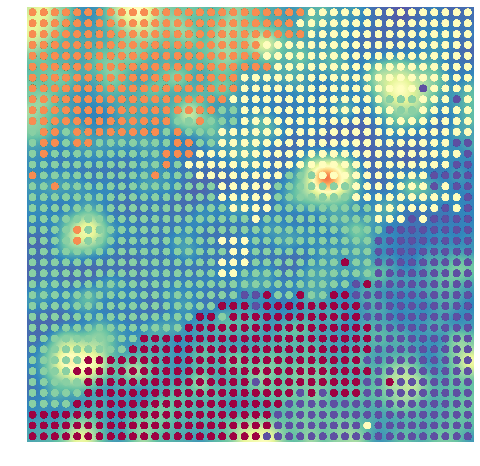

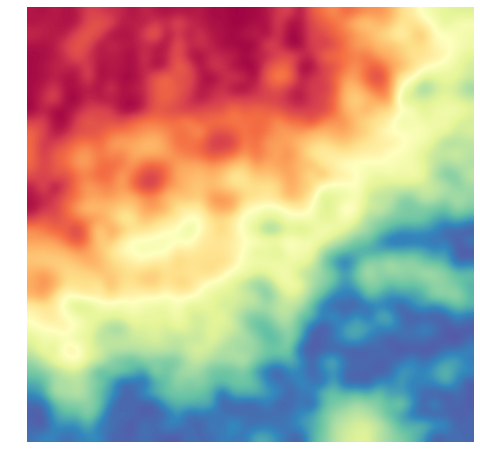

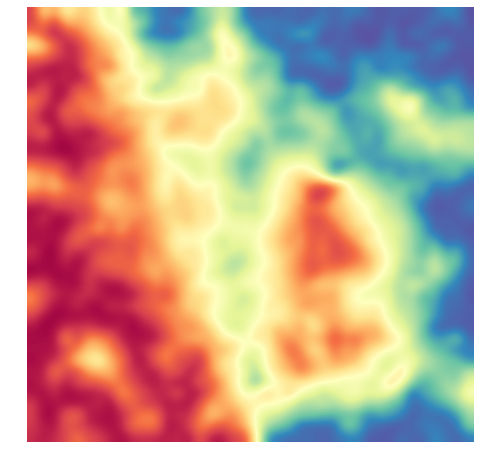

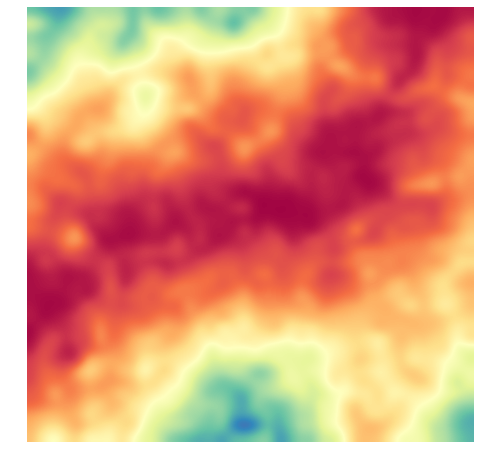

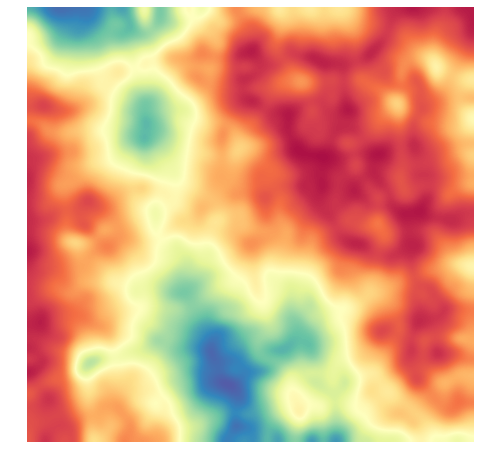

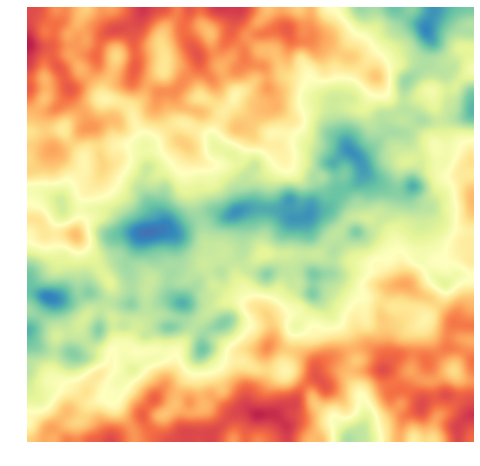

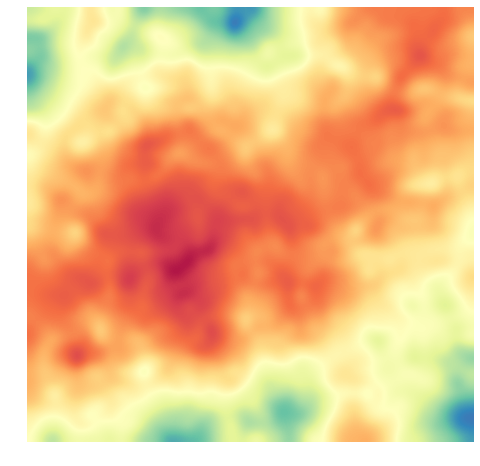

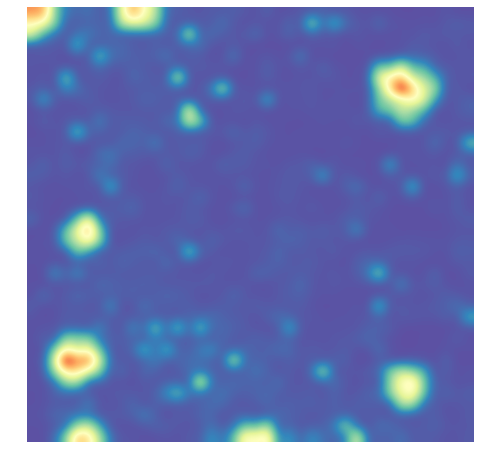

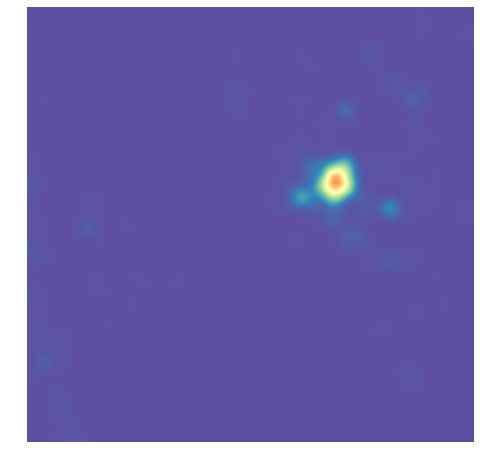

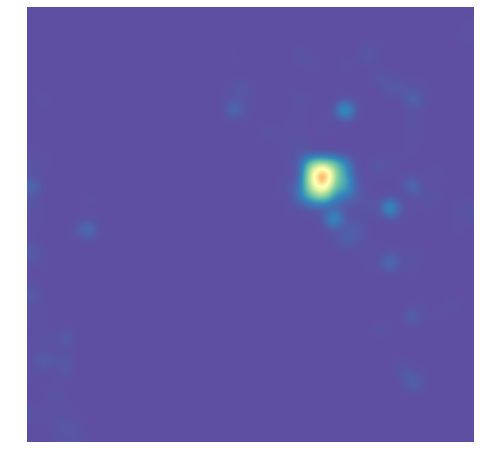

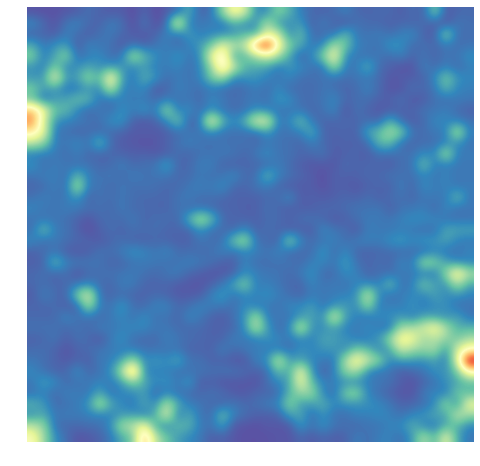

(<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

In [9]:
algorithm = KMeans(n_clusters = 5)
som.cluster(algorithm=algorithm)
draw_umatrix()

In [9]:
# We find own data-points for each clusters
clusters = find_clusters(labels)

{
    "0": [
        698,
        699,
        1091,
        1092,
        1106,
        1107,
        1114,
        1115,
        1217,
        1218,
        1364,
        1365,
        1386,
        1387,
        1388,
        1389,
        1400,
        1401,
        1402,
        1412,
        1413,
        1424,
        1426,
        1431,
        1432,
        1446,
        1449,
        1450,
        1451,
        1453,
        1454,
        1455,
        1456,
        1469,
        1471,
        1472,
        1473,
        1474,
        1475,
        1476,
        1477,
        1478,
        1479,
        1568,
        1569,
        1570,
        1571,
        1572,
        1573,
        1596,
        1597,
        1641,
        1642,
        1643,
        1644,
        1658,
        1663,
        1664,
        1665,
        1666,
        1667,
        1668,
        1669,
        1670,
        1671,
        1672,
        1673,
        1674,
        1675,
        1687,
        1

In [10]:
# calling DataFrame for all clusters
for i in range(len(clusters)):
    print("Cluster: {}".format(i))
    cluster_frame = cluster_data_frame(str(i), clusters)
#     print(cluster_frame, "\n"*10)
    print(cluster_frame.describe())

Cluster: 0
                day          hour          DEWP          HUMI          PRES  \
count  28328.000000  28328.000000  28328.000000  28328.000000  28328.000000   
mean     203.199273     17.445143     17.866281     67.756555   1006.797705   
std       68.010013      3.720154      4.848303     17.899050      6.752142   
min        2.000000      6.000000     -2.000000     14.000000    981.900000   
25%      155.000000     14.000000     14.200000     54.140000   1002.500000   
50%      205.000000     18.000000     18.000000     69.000000   1006.350000   
75%      255.000000     21.000000     22.000000     83.000000   1011.000000   
max      364.000000     23.000000     28.000000    100.000000   1033.000000   

               TEMP           Iws  precipitation         Iprec    average_PM  
count  28328.000000  28328.000000   28328.000000  28328.000000  28328.000000  
mean      24.903029     19.608300       0.223828      1.000579     52.427972  
std        5.787424     41.630761       

In [11]:
import jdc
import numpy as np
import itertools 


class SOM(object):
    
    
    def __init__(self,h,w,dim_feat):
        """
            Construction of a zero-filled SOM.
            h,w,dim_feat: constructs a (h,w,dim_feat) SOM.
        """
        self.shape = (h,w,dim_feat)
        self.som = np.zeros((h,w,dim_feat))

        # Training parameters
        self.L0 = 0.0
        self.lam = 0.0
        self.sigma0 = 0.0
    
    
    def train(self,data,L0,lam,sigma0,initializer=np.random.rand):
        """ 
            Training procedure for a SOM.
            data: a N*d matrix, N the number of examples, 
                  d the same as dim_feat=self.shape[2].
            L0,lam,sigma0: training parameters.
            initializer: a function taking h,w and dim_feat (*self.shape) as 
                         parameters and returning an initial (h,w,dim_feat) tensor.
        """
        self.L0 = L0
        self.lam = lam
        self.sigma0 = sigma0
        self.data = data
        self.som = initializer(*self.shape)
        bmu_list = []
        
        for t in itertools.count():
            if self.sigma(t) < 0.5:
                break
            i_data =  np.random.choice(range(len(data)))

            bmu = self.find_bmu(data[i_data])
            self.update_som(bmu,data[i_data],t)
            # check out
            bmu_list.append(bmu)
        return bmu_list
            
    
    def find_bmu(self, input_vec):
        """
            Find the BMU of a given input vector.
            input_vec: a d=dim_feat=self.shape[2] input vector.
        """
        list_bmu = []
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist = np.linalg.norm((input_vec-self.som[y,x]))
                list_bmu.append(((y,x),dist))
        list_bmu.sort(key=lambda x: x[1])
        return list_bmu[0][0]
    
    
    def update_bmu(self,bmu,input_vector,t):
        """
            Update rule for the BMU.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        self.som[bmu] += self.L(t)*(input_vector-self.som[bmu])

        
    def L(self, t):
        """
            Learning rate formula.
            t: current time.
        """
        return self.L0*np.exp(-t/self.lam) 

    
    
    def update_som(self,bmu,input_vector,t):
        """ 
            Calls the update rule on each cell.
            bmu: (y,x) BMU's coordinates.
            input_vector: current data vector.
            t: current time.
        """
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                dist_to_bmu = np.linalg.norm((np.array(bmu)-np.array((y,x))))
                self.update_cell((y,x),dist_to_bmu,input_vector,t)

                
    def update_cell(self,cell,dist_to_bmu,input_vector,t):
        """ 
            Computes the update rule on a cell.
            cell: (y,x) cell's coordinates.
            dist_to_bmu: L2 distance from cell to bmu.
            input_vector: current data vector.
            t: current time.
        """
        self.som[cell] += self.N(dist_to_bmu,t)*self.L(t)*(input_vector-self.som[cell])
        # My attempts
#         self.new_som.append(self.som[cell])

        
    def N(self,dist_to_bmu,t):
        """ 
            Computes the neighbouring penalty.
            dist_to_bmu: L2 distance to bmu.
            t: current time.
        """
        curr_sigma = self.sigma(t)
        return np.exp(-(dist_to_bmu**2)/(2*curr_sigma**2))

    
    def sigma(self, t):
        """
            Neighbouring radius formula.
            t: current time.
        """
        return self.sigma0*np.exp(-t/self.lam)
    
    
    def quantization_error(self):
        """ 
            Computes the quantization error of the SOM.
            It uses the data fed at last training.
        """
        bmu_dists = []
        for input_vector in self.data:
            bmu = self.find_bmu(input_vector)
            bmu_feat = self.som[bmu]
            bmu_dists.append(np.linalg.norm(input_vector-bmu_feat))
        return np.array(bmu_dists).mean()

In [13]:
som_square = SOM(40,40, 10)
train_som = som_square.train(X,L0=0.1,lam=1e2,sigma0=38)
bmu = train_som
mapp = som_square.som

In [14]:
print(som_square.quantization_error())

0.35722685865995024


In [15]:
specific_cluster0 = cluster_data('0', clusters)
specific_cluster1 = cluster_data('1', clusters)
specific_cluster2 = cluster_data('2', clusters)
specific_cluster3 = cluster_data('3', clusters)
specific_cluster4 = cluster_data('4', clusters)

Quantity strings in clusters - 28328 
 Approximate map size - 29.009415643869318 
Quantity strings in clusters - 25462 
 Approximate map size - 28.24607647545864 
Quantity strings in clusters - 17160 
 Approximate map size - 25.592594939796797 
Quantity strings in clusters - 14937 
 Approximate map size - 24.720135526662403 
Quantity strings in clusters - 14797 
 Approximate map size - 24.662007223361393 


In [0]:
n_rows, n_columns = 29, 29
som = somoclu.Somoclu(n_columns, n_rows, data=specific_cluster, maptype="toroid", initialization="pca")
%time som.train(epochs=1000,radius0=28, radiusN=1,radiuscooling="exponential",scale0=0.1, scaleN=0.035, scalecooling="exponential")

CPU times: user 16min 9s, sys: 814 ms, total: 16min 9s
Wall time: 4min 22s


In [0]:
%time som.train(epochs=10000,radius0=1,radiusN=0.000001,radiuscooling="exponential",scale0=0.035, scaleN=0.001, scalecooling="exponential")
e_t = calculate_topographical_error(som, n_rows, n_columns)
print("The topographical error obtained is: %s"%e_t)

CPU times: user 2h 22min 41s, sys: 10.5 s, total: 2h 22min 52s
Wall time: 38min 37s
The topographical error obtained is: 0.5026902847469923


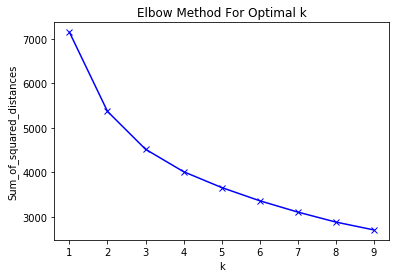

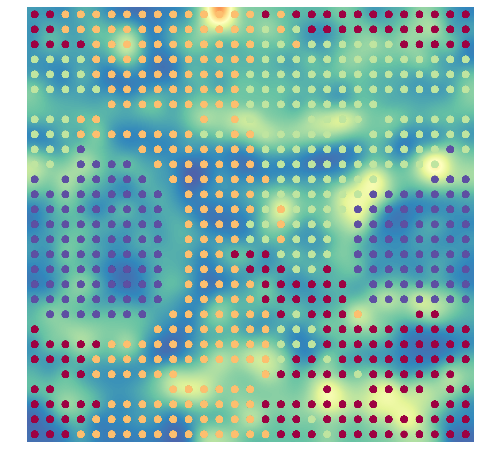

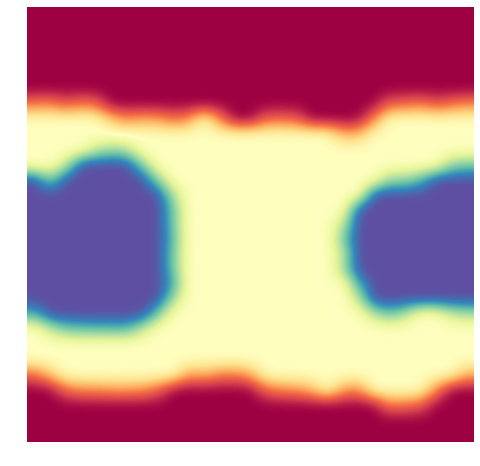

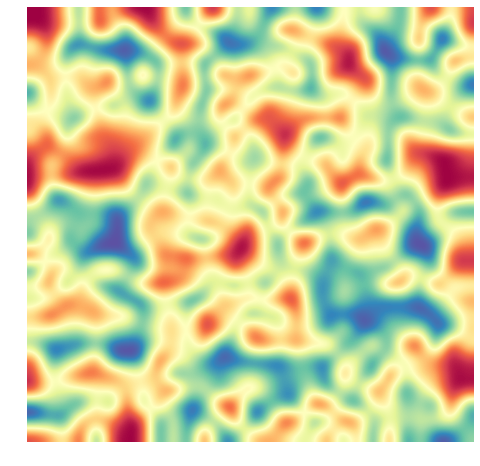

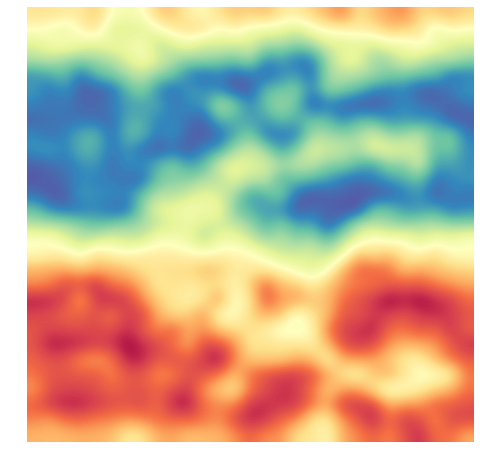

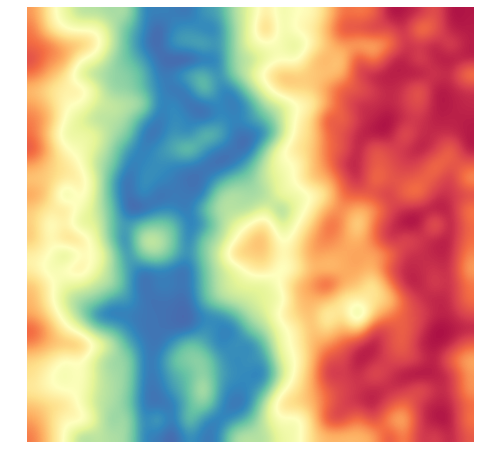

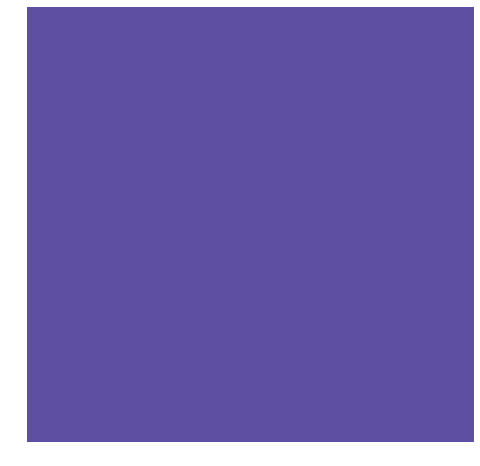

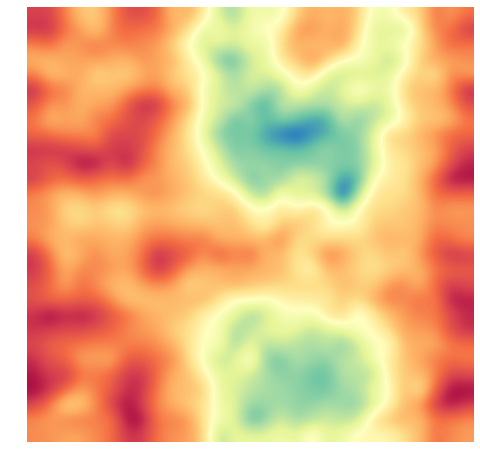

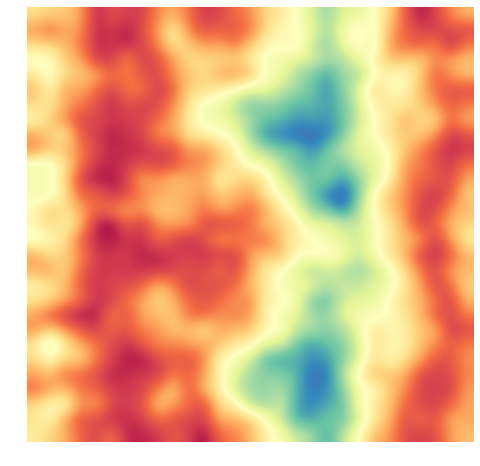

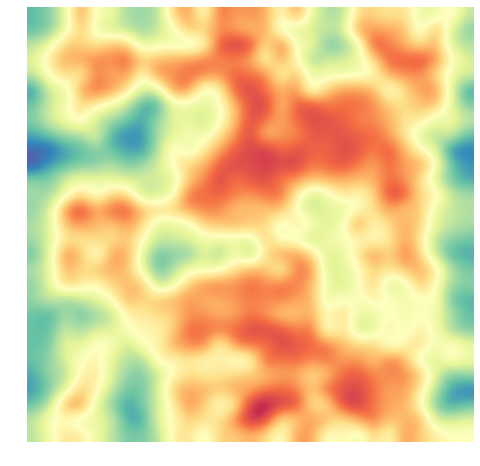

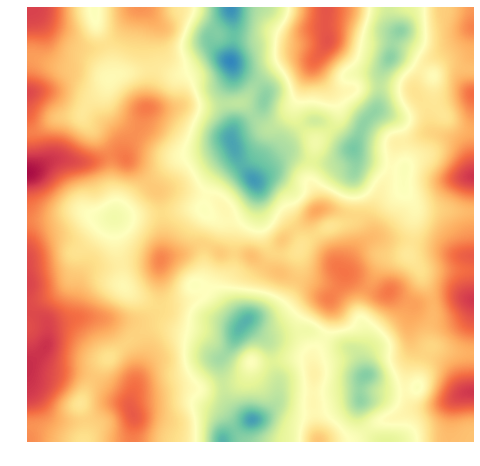

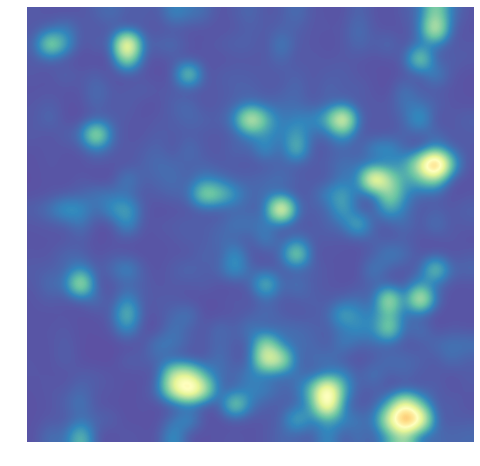

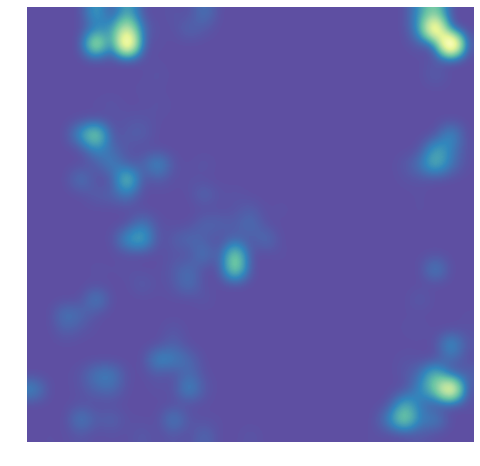

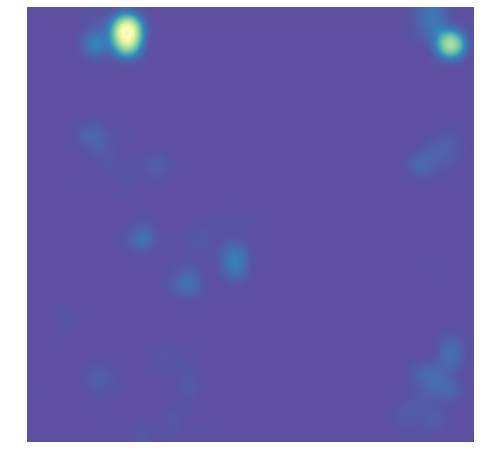

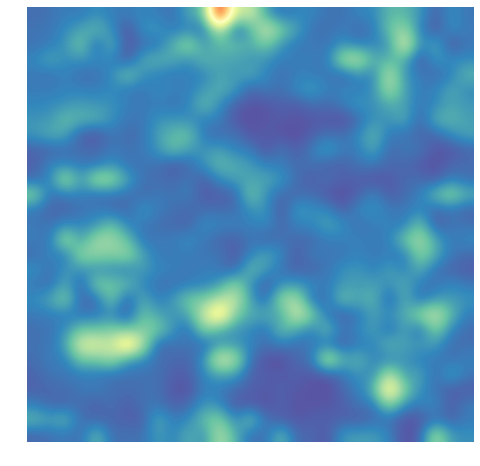

(<module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>,
 <module 'matplotlib.pyplot' from '/home/valyay/.local/lib/python3.5/site-packages/matplotlib/pyplot.py'>)

In [0]:
elbow_plot(specific_cluster)

algorithm = KMeans(n_clusters = 4)
som.cluster(algorithm=algorithm)
draw_umatrix()

In [0]:
print("asdasdasd")

In [0]:
labels = range(specific_cluster.shape[0])
clusters = find_clusters(labels)
quantization = quant_err(specific_cluster)
print(quantization)

{
    "0": [
        2570,
        2571,
        2572,
        2573,
        2574,
        2575,
        2576,
        2577,
        2578,
        2579,
        2580,
        2581,
        2582,
        2583,
        2584,
        2585,
        2586,
        2587,
        2588,
        2589,
        2590,
        2591,
        2592,
        2593,
        2594,
        2595,
        2596,
        2597,
        2598,
        2599,
        2600,
        2601,
        2602,
        2603,
        2604,
        2605,
        2606,
        2607,
        2608,
        2609,
        2610,
        2611,
        2612,
        2613,
        2614,
        2615,
        2616,
        2617,
        2618,
        2619,
        2620,
        2621,
        2622,
        2623,
        2624,
        2625,
        2626,
        2627,
        2628,
        2629,
        2630,
        2631,
        2632,
        2633,
        2634,
        2635,
        2636,
        2637,
        2638,
        2639,
       

0.9042089794236504


In [0]:
print(mapp.quantization_error())

AttributeError: 'numpy.ndarray' object has no attribute 'quantization_error'

In [0]:
print(som_square.quantization_error())

0.4055960377532623


In [0]:
som_square = SOM(29,29, 13)
train_som = som_square.train(specific_cluster,L0=0.8,lam=1e2,sigma0=10)
bmu = train_som
mapp = som_square.som

In [0]:
print(som_square.quantization_error())

0.29963716197197615


In [0]:
som_square = SOM(40,40, 13)
train_som = som_square.train(specific_cluster,L0=0.8,lam=1e2,sigma0=10)
bmu = train_som
mapp = som_square.som
print(som_square.quantization_error())

0.2820734871115981
